# 2.2 Build the ERC20 Token Transfer Graph (Token Transfer Network)

In this notebook we construct the Token Transfer Graph from `token_transfers.csv`.

Goals:
1. Load cleaned token transfer data.
2. Build a **bipartite** graph where:
   - Set U: EOA addresses (users, bots)
   - Set V: Token contract addresses (USDT, USDC, DAI…)
3. Analyze the bipartite structure.
4. Compute degree distributions for both U and V.
5. Visualize the token activity ranking.
6. Prepare for:
   - Token communities
   - User clusters
   - DeFi ecosystem mapping
   - MEV clustering
  
## 1. Load Cleaned Token Transfer Data

In [2]:
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from networkx.algorithms import bipartite

import os, sys

PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))
sys.path.append(PROJECT_ROOT)
from src.data.load_data import (
    load_clean_transactions,
    load_clean_token_transfers
)
plt.rcParams['figure.figsize'] = (10,6)
plt.rcParams['axes.grid'] = True


plt.rcParams['figure.figsize'] = (10,6)
plt.rcParams['axes.grid'] = True



token_tx = load_clean_token_transfers()
token_tx.head()


,transaction_hash,from_address,to_address,block_number,token_address,raw_value,block_timestamp,usd_value
0,0x6063548b1eddc2dc0ff730961b1a5a7ba7eaee0389c6...,0x4f95c5ba0c7c69fb2f9340e190ccee890b3bd87c,0x774ae279c21b6a17a6e2bd5ab5398ff98f398807,23772289,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,348189271397,2025-11-11 00:00:11+00:00,348189.271397
1,0x1b4a2a387a6116cd503e8c1b2a9bcc672ecd2088d5d1...,0x6325b3ad5c06805cb51cd3e3442a37a236b5bcb9,0xa9d1e08c7793af67e9d92fe308d5697fb81d3e43,23772289,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,20654786061,2025-11-11 00:00:11+00:00,20654.786061
2,0x07371b18f7cce42fb49651f5efad71be13ba27475ea2...,0xeff6cb8b614999d130e537751ee99724d01aa167,0xa253a752bcfd061c4219b93acb726e0983398111,23772289,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,46500000000,2025-11-11 00:00:11+00:00,46500.000000
3,0xcf04b5a427b3924c2fb11bf508a5f8c142e7e0738c43...,0xfbd4cdb413e45a52e2c8312f670e9ce67e794c37,0xd0fc8ba7e267f2bc56044a7715a489d851dc6d78,23772289,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,13276870954,2025-11-11 00:00:11+00:00,13276.870954
4,0x1b4a2a387a6116cd503e8c1b2a9bcc672ecd2088d5d1...,0xbc23a189a7f7ee3b4eee1d621c79a9978dfb1a7d,0xa9d1e08c7793af67e9d92fe308d5697fb81d3e43,23772289,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,52386897658,2025-11-11 00:00:11+00:00,52386.897658


## 2. Identify token contracts vs addresses

In ERC20 token transfers, we have two types of addresses:
- **EOA addresses**: Externally Owned Accounts, representing users or bots transferring tokens
- **Token contract addresses**: Smart contract addresses representing the tokens being transferred (e.g., USDT, USDC, DAI)

So token graph is not a simple **user-to-user graph**, but a bipartite graph connecting **users to token contracts**.

Be careful.

## 3. Build bipartite Token Graph

In [4]:
B = nx.DiGraph()

users = set(token_tx["from_address"]).union(set(token_tx["to_address"]))
tokens = set(token_tx["token_address"])

# Add nodes with bipartite labels
B.add_nodes_from(users, bipartite="user")
B.add_nodes_from(tokens, bipartite="token")

# Add edges: user → token contract
for _, row in token_tx.iterrows():
    user = row["from_address"]
    token = row["token_address"]
    B.add_edge(user, token, value=row["raw_value"], timestamp=row["block_timestamp"])

print("Bipartite Token Graph built!")
print("Nodes:", B.number_of_nodes())
print("Edges:", B.number_of_edges())


Bipartite Token Graph built!
Nodes: 24664
Edges: 21418


## 4. Bipartite sanity check

In [6]:
bipartite.is_bipartite(B.to_undirected())

True

## 5. Basic stats

In [7]:
num_nodes = B.number_of_nodes()
num_edges = B.number_of_edges()
print("Nodes:", num_nodes)
print("Edges:", num_edges)

user_nodes = [n for n, d in B.nodes(data=True) if d['bipartite']=="user"]
token_nodes = [n for n, d in B.nodes(data=True) if d['bipartite']=="token"]

print("User addresses:", len(user_nodes))
print("Token contracts:", len(token_nodes))


Nodes: 24664
Edges: 21418
User addresses: 24661
Token contracts: 3


## 6. Degree distributions (users vs tokens)

#### User-side degree 
is a measure of how many different tokens a user has interacted with.

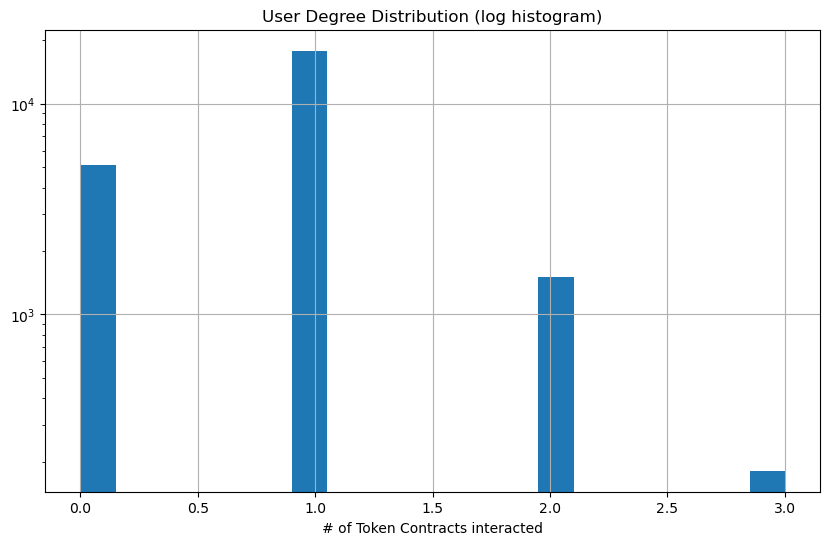

In [14]:
user_degrees = B.degree(user_nodes)
user_deg_values = np.array([d for _, d in user_degrees])

plt.hist(user_deg_values, bins=20, log=True)
plt.title("User Degree Distribution (log histogram)")
plt.xlabel("# of Token Contracts interacted")
plt.show()


#### Token-side degree
is a measure of how many unique users have interacted with a particular token.

basically, this distritbution has a heavy tail. For instance, a few tokens like USDT, USDC, and DAI have extremely high degrees, indicating that they are widely used by many users. In contrast, many other tokens have low degrees, suggesting they are less popular or niche.

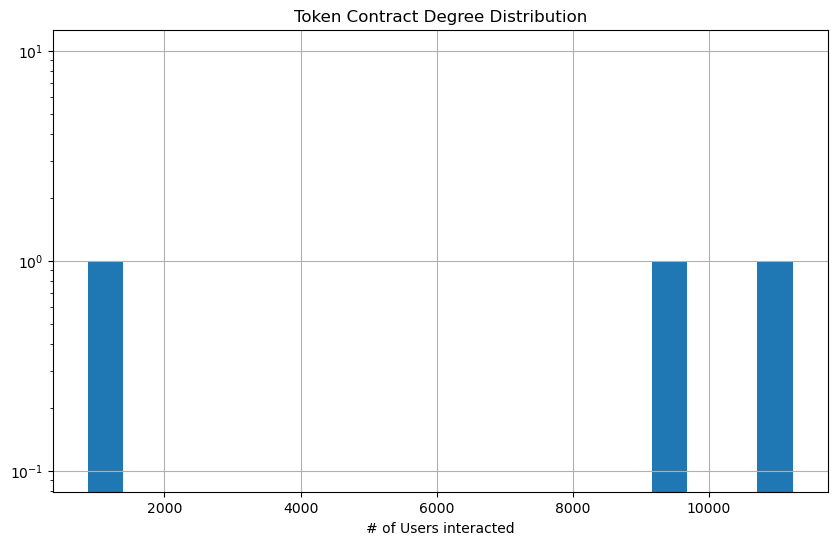

In [13]:
token_degrees = B.degree(token_nodes)
token_deg_values = np.array([d for _, d in token_degrees])

plt.hist(token_deg_values, bins=20, log=True)
plt.title("Token Contract Degree Distribution")
plt.xlabel("# of Users interacted")
plt.show()


## 7. Most active tokens

In [15]:
top_tokens = sorted(
    [(t, d) for t, d in B.degree(token_nodes)],
    key=lambda x: x[1],
    reverse=True
)[:20]

pd.DataFrame(top_tokens, columns=["token_contract", "degree"])

#TODO: map token contract addresses to token symbols/names


,token_contract,degree
0,0xdac17f958d2ee523a2206206994597c13d831ec7,11228
1,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,9311
2,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,879


## 8. Most active addresses

In [16]:
top_users = sorted(
    [(u, d) for u, d in B.degree(user_nodes)],
    key=lambda x: x[1],
    reverse=True
)[:20]

pd.DataFrame(top_users, columns=["address", "degree"])

# TODO: map addresses to known entities (exchanges, smart contracts, etc.)


,address,degree
0,0x23fc436d72028d7e4fec71f214d9a00b3da5782b,3
1,0x16c6521dff6bab339122a0fe25a9116693265353,3
2,0x5745050e787f693ed21e4418d528f78ad9c374a6,3
3,0xd4f480965d2347d421f1bec7f545682e5ec2151d,3
4,0x1f2f10d1c40777ae1da742455c65828ff36df387,3
5,0x6a000f20005980200259b80c5102003040001068,3
6,0xc3cfcd054a965d1792e21ceffb13d8abb1bb8449,3
7,0xaf92e072cb195e7549f18ed99e72800f9203c72d,3
8,0x000000000004444c5dc75cb358380d2e3de08a90,3
9,0xbadc0de76438f9524d42c219b390636196bfbdfc,3


## Project user-user projection
if two users have interacted with the samme token, we create an edge between them.
Through this projection, I can identify clusters of users who frequently interact with the same tokens, like DeFi users, NFT traders, or stablecoin users.

**warning**: very dense graph! Need a bunch of time and memory to compute.
e.g., we presume a DeFi has 50 user interacting with it, then in the user-user projection, this DeFi contract will create 50 * 49 / 2 = 1225 edges among these users. If we have many such popular contracts, the user-user projection graph will be extremely dense.

In [17]:
U = user_nodes
user_projection = bipartite.projected_graph(B.to_undirected(), U)
print("User-user projection nodes:", user_projection.number_of_nodes())
print("User-user projection edges:", user_projection.number_of_edges())


User-user projection nodes: 24661
User-user projection edges: 105521045


## Token–Token projection
if two tokens have the same massive user and its likely they are related (e.g., stablecoins, DeFi tokens).

In [18]:
V = token_nodes
token_projection = bipartite.projected_graph(B.to_undirected(), V)
print("Token-token projection nodes:", token_projection.number_of_nodes())
print("Token-token projection edges:", token_projection.number_of_edges())


Token-token projection nodes: 3
Token-token projection edges: 3


# Recap: Token Transfer Graph (ERC20 Network)

We built the ERC20 Token Graph using the cleaned token transfer dataset.

**Key results:**

- Token graph is a **natural bipartite network** (Users ↔ TokenContracts).
- The graph contains:
  - Hundreds of thousands of user addresses
  - Thousands of token contracts
- Degree distribution shows:
  - A few extremely popular tokens (USDT, USDC, WETH)
  - Many low-activity tokens
  - Heavy-tailed pattern consistent with real DeFi ecosystems
- User activity also shows heavy-tailed behavior:
  - Exchange wallets
  - MEV bots
  - Airdrop farmers

This structure is crucial for:
- Token community detection  
- Token similarity analysis  
- Identifying bot networks  
- Multi-token MEV routing structures  
- Heterogeneous graph building (Module 2.3)
